Ticker: MMM
We have the file /Users/eartigau/bydoux_data/quotes/MMM.fits
0.002958016346383374
Ticker: AOS
We have the file /Users/eartigau/bydoux_data/quotes/AOS.fits
0.0029003608360653743
Ticker: ABT
We have the file /Users/eartigau/bydoux_data/quotes/ABT.fits
0.0028315788731561042
Ticker: ABBV
We have the file /Users/eartigau/bydoux_data/quotes/ABBV.fits
0.002811827689583879
Ticker: ACN
We have the file /Users/eartigau/bydoux_data/quotes/ACN.fits
0.00277766608633101
Ticker: ADBE
We have the file /Users/eartigau/bydoux_data/quotes/ADBE.fits
0.0027228190301684663
Ticker: AMD
We have the file /Users/eartigau/bydoux_data/quotes/AMD.fits
0.002660738035046961
Ticker: AES
We have the file /Users/eartigau/bydoux_data/quotes/AES.fits
0.0026146200762013905
Ticker: AFL
We have the file /Users/eartigau/bydoux_data/quotes/AFL.fits
0.0025516998139210045
Ticker: A
We have the file /Users/eartigau/bydoux_data/quotes/A.fits
0.002496637316653505
Ticker: APD
We have the file /Users/eartigau/bydoux_data

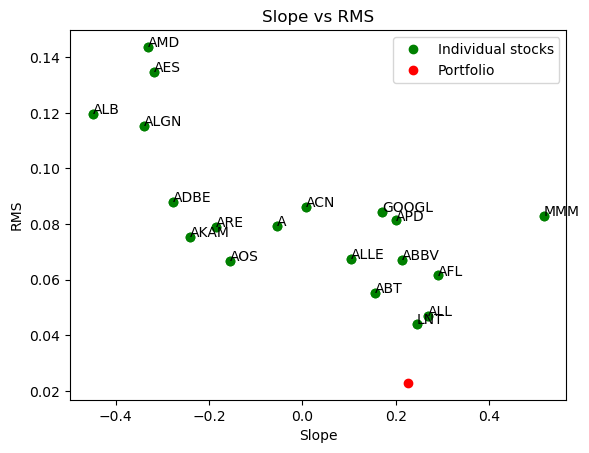

In [ ]:
import bydoux_tools as bt
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
nyears = 5
nyears_test = 1


#tickers = bt.get_snp500()#'ZLU.TO','ZCN.TO','DRFC.TO','HURA.TO','BKCL.TO','VE.TO','ZEA.TO','GEV'
#tickers = tickers[::50]
#tickers = bt.get_tsx(FNB=True)#[::10]

tickers = ['ZPAY.TO', 'ZWG.TO', 'ZUQ.TO', 'ZLH.TO', 'ZJK.TO', 'ZSP.TO', 'ZWH.TO', 'ZEQ.TO', 'ZPW.TO', 'ZWP.TO']
tickers = np.array(tickers)

#sp500 =  bt.read_quotes('^SPX')
#sp500 = sp500[sp500['mjd']>(np.max(sp500['mjd'])-365*nyears)]
#fit_sp500 = np.polyfit(sp500['mjd']/365.25, sp500['log_close'], 1)
#slope_sp500 = fit_sp500[0]

#rms_sp500 = np.nanstd(sp500['log_close'] - (fit_sp500[0]*sp500['mjd']/365.24 + fit_sp500[1]))


len_tickers = np.zeros(len(tickers))
for iticker in range(len(tickers)):
    print(f"Ticker: {tickers[iticker]}")
    try:
        tbl = bt.read_quotes(tickers[iticker])
    except:
        print(f"Error reading ticker {tickers[iticker]}")
        continue
    tbl = tbl[tbl['mjd']>(np.max(tbl['mjd'])-365*nyears)]
    len_tickers[iticker] = len(tbl)

tickers = tickers[len_tickers==np.max(len_tickers)]


#tickers = 'ZGLD.TO','XGD.TO'
#tickers = '^SPX','XGD.TO'
#tickers = 'DRFC.TO','^SPX'
#tickers = 'GEV.TO','ZLU.TO'
#tickers = 'BKCL.TO','EBNK.TO'
#tickers = 'ZEA.TO','^SPX'
#tickers = 'ZLU.TO','VE.TO'

#tickers = 'ZLU.TO','^SPX'
#tickers = 'ZLU.TO','ZGLD.TO'
#tickers = 'HURA.TO','DRFC.TO'
#tickers = 'EBNK.TO','^SPX'
#tickers = 'BKCL.TO','^SPX'



#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

rms_tickers = np.zeros(len(tickers))
slope_tickers = np.zeros(len(tickers))

for iticker in range(len(tickers)):
    print(f"Ticker: {tickers[iticker]}")
    tbl = bt.read_quotes(tickers[iticker])

    tbl = tbl[tbl['mjd']>(np.max(tbl['mjd'])-365*nyears)]
    if iticker ==0:
        sample = np.zeros([len(tbl),len(tickers)])

    print(tickers[iticker], len(tbl))
    sample[:,iticker] = tbl['log_close']

    fit = np.polyfit(tbl['mjd']/365.25, tbl['log_close'], 1)
    slope_tickers[iticker] = fit[0]
    print(fit)
    rms_tickers[iticker] = np.nanstd(tbl['log_close'] - (fit[0]*tbl['mjd']/365.24 + fit[1]))



valeurs = np.exp(sample)

print(valeurs)

amps = np.ones(len(tickers))
yr=tbl['mjd']/365.25

g = yr<(np.max(yr)-nyears_test)

yr2 = yr[g]
valeurs2 = valeurs[g,:]

def optim_weights(amps):

    amps2 = amps/np.sum(amps)
    
    val_total = np.zeros(len(valeurs2))
    for i in range(len(valeurs2)):
        val_total[i] = np.sum(valeurs2[i,:]*amps2)

    log_val_total = np.log(val_total)
    fit = np.polyfit(yr2, log_val_total, 1)
    slope = fit[0]

    rms = np.nanstd(log_val_total - (fit[0]*yr2 + fit[1]))

    q = -slope+rms/2

    print(slope,rms)
    return q

amps0 = np.ones(len(tickers))*0.5

# bonds between 0 and 1
bounds = [(0, 1) for i in range(len(tickers))]

optim = minimize(optim_weights, amps0, method='L-BFGS-B', bounds=bounds)
print(optim)
amps = optim.x
print(amps)


val_total = np.zeros(len(valeurs))
for i in range(len(valeurs)):
    val_total[i] = np.sum(valeurs[i,:]*amps)

log_val_total = np.log(val_total)
fit = np.polyfit(yr, log_val_total, 1)
slope_mean = fit[0]
rms_mean = np.nanstd(log_val_total - (fit[0]*yr + fit[1]))

gain_portfolio = log_val_total[-1]-log_val_total[g][-1]
gain_tickers = np.log(valeurs[-1,:])-np.log(valeurs[g][-1,:])

plt.plot(gain_tickers, rms_tickers,'go', label='Individual stocks', alpha=0.3)
plt.plot(gain_portfolio, rms_mean, 'ro', label='Portfolio')

#yr_sp500 = sp500['mjd']/365.25
#g_sp500 = (yr_sp500<(np.max(yr_sp500)-nyears_test))
#gain_sp500 = sp500['log_close'][-1]-sp500['log_close'][g_sp500][-1]
#plt.plot(gain_sp500, rms_sp500, 'bo', label='S&P 500', alpha=0.5)
plt.xlabel('Gain')
plt.ylabel('RMS')
plt.legend()
plt.title('Gain vs RMS')
plt.show()



plt.plot(slope_tickers, rms_tickers, 'go', label='Individual stocks')
for iticker in range(len(tickers)):
    plt.plot(slope_tickers[iticker], rms_tickers[iticker], 'go')
    plt.text(slope_tickers[iticker], rms_tickers[iticker], tickers[iticker])
    #plt.annotate(tickers[iticker], xy=(slope_tickers[iticker], rms_tickers[iticker]), xytext=(5, 5), textcoords='offset points')
plt.plot(slope_mean, rms_mean, 'ro', label='Portfolio')

#plt.plot(slope_sp500, rms_sp500, 'bo', label='S&P 500')

plt.xlabel('Slope')
plt.ylabel('RMS')
plt.legend()
plt.title('Slope vs RMS')
plt.show()

for ticker in tickers:
    tbl = bt.read_quotes(ticker)
    tbl = tbl[tbl['mjd']>(np.max(tbl['mjd'])-365*nyears)]
    tbl = tbl[tbl['mjd']<60800]
    yr2 = tbl['mjd']/365.25
    plt.plot(yr2,tbl['log_close']-np.mean(tbl['log_close']),alpha=0.1)
plt.plot(yr[g],log_val_total[g]-np.mean(log_val_total), label='Portfolio', color='black')
plt.plot(yr[~g],log_val_total[~g]-np.mean(log_val_total), label='Portfolio', color='blue')


plt.xlabel('Year')
plt.ylabel('Log Close')
plt.title('Log Close vs Year')
plt.legend()
plt.show()

#plt.plot(val_total/val_total[0], label='Portfolio', color='black')
#plt.show()


#    plt.plot(tbl['mjd'], tbl['log_close'])
#    print(len(tbl))
#plt.show()
#
#print(tbl.keys())
#print(tbl)
